In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
import glob
import pickle
import sys
import os
from scipy import odr
import yaml
plt.style.use("~/evanstyle.mplstyle")

sys.path.append("../CombinedData/")
import Dataset

In [25]:
topdir = "../../data/Run7/charge-calibration/"
config_f = "../configs/run7_config.yaml"

#charge only analysis, so just load the AD2 dataframe. It is 3GB
df, date = pickle.load(open(topdir+"prereduced_ad2.p", "rb"))

In [28]:
df.iloc[0]["Data"][1]

array([   0.59044374,    0.25013035,    0.59044374, ..., -100.14232139,
       -100.14232139, -100.14232139])

### These functions can later be used to port into the Dataset.py class

In [59]:
#this is a fitfunc intended for use with the scipy.ODR
#class. It uses t0 as a fixed, known parameter, the start
#time of the falling exponential. 
def fitfunc_exp(beta, x, t0):
    return beta[0]*np.exp(-(x - t0)/beta[1])

#fit to exponential with a fixed start time, which 
#may vary from event to event (depending on the digitizer settings)
def model_wrapper(fixed_t0):
    return lambda beta, x: fitfunc_exp(beta, x, fixed_t0)

def model_wrapper_fixedtau(fixed_t0, fixed_tau):
    return lambda beta, x: fitfunc_exp([beta[0], fixed_tau], x, fixed_t0)

#analyze charge waveform. Here the event is a row
#of the charge ad2 dataframe for an event. config is
#the config dict from the yaml file. 
def charge_ana(event, config, debug=False):

    #get the peak to peak swing of the signal on channel 0, which
    #is across a 20 pF capacitor, so then defines the charge injected.
    #Do so by averaging 300 microseconds at the beginning and end of buffer
    dT = event["dT"]
    chg = event["Data"][1]
    chg_vi = np.mean(chg[:int(300/(dT*1e6))])
    chg_vf = np.mean(chg[-int(300/(dT*1e6)):])
    capacitance = 20 #pF
    chg_injected = (chg_vf - chg_vi)*capacitance/1000 #pC

    amp_thr = config["glitch"]["fit_amplitude_threshold"]*1000 #mV, threshold for decided one analysis vs another based on low amplitude. 

    #get waveform np arrays and time np arrays. 
    v = np.array(event["Data"][0])
    ts = np.array(np.linspace(0, len(v)*dT*1e6, len(v))) #times in microseconds

    #find the abs-max sample and the sign of that sample. 
    max_abs_index = np.argmax(np.abs(v))
    max_abs_t = ts[max_abs_index]
    trig_idx = max_abs_index
    max_val = v[max_abs_index] #independent of polarity

    #check to make sure the max index sample is close to the middle of the
    #buffer, to assure the assumption about trigger time is true. 
    trigger_aligned_check = 200 #microseconds
    if(np.abs(max_abs_t - ts[int(len(ts)/2)]) > trigger_aligned_check):
        #print(max_abs_t)
        #print(ts[int(len(ts)/2)])
        #print("Trigger is not aligned with this event, tossing it")
        #return None
        pass
    
    #calculate noise for the waveform based on baseline samples
    bl_wind = config["glitch"]["baseline_window"]
    noise = np.std(v[bl_wind[0]:bl_wind[1]])
    
    #if the max val is above the threshold for doing a fit based analysis
    if(np.abs(max_val) > amp_thr):
        #get a chunk of data after the trigger time so as 
        #to fit an exponential with a start time t0. 
        fit_time_buffer = int(10/(dT*1e6)) #samples, time after the trigger to which to include the fit
        ts_trim = ts[trig_idx+fit_time_buffer:]
        v_trim = v[trig_idx+fit_time_buffer:]
        initial_guess = [max_val, 400] #400 is the estimated tau from previous explorative fits. 

        #ODR based objects for performing fit
        odr_model = odr.Model(model_wrapper(max_abs_t))
        odr_data = odr.Data(ts_trim, v_trim)
        odr_inst = odr.ODR(odr_data, odr_model, beta0=initial_guess)
        odr_result = odr_inst.run()
        amp = odr_result.beta[1]
        tau = odr_result.beta[0]

        #redo the analysis with a fixed tau based on prior analyses. 
        odr_model = odr.Model(model_wrapper_fixedtau(max_abs_t, 384))
        odr_inst = odr.ODR(odr_data, odr_model, beta0=[max_val])
        odr_result = odr_inst.run()
        amp_fixed = odr_result.beta[0]

        #to confirm with plots
        if(debug and odr_result.beta[1] < 360):
            fig, ax = plt.subplots()
            ax.plot(ts, v)
            ax.plot(ts_trim, fitfunc_exp(odr_result.beta, ts_trim, max_abs_t), label="{:.2f} e^(-t/{:.2f})".format(*odr_result.beta))
            ax.set_xlabel("[us]")
            ax.set_ylabel('[mV]')
            ax.legend()
            plt.show()

        s = pd.Series(dtype=float)
        s["tau"] = amp
        s["amp"] = tau
        s["amp_fixed"] = amp_fixed
        s["max"] = max_val
        s["noise"] = noise
        s["charge"] = chg_injected
        return s
    
    else:
        s = pd.Series(dtype=float)
        s["tau"] = 0
        s["amp"] = max_val
        s["amp_fixed"] = max_val
        s["max"] = max_val
        s["noise"] = noise
        s["charge"] = chg_injected
        return s



        
        
    
    
    


In [30]:

def load_config(config_file):
        if(os.path.isfile(config_file)):
            #safe read this yaml file
            with open(config_file, 'r') as stream:
                try:
                    config = yaml.safe_load(stream)
                except:
                    print("Had an issue reading the config file, make sure it is a .yaml or .yml file")
                    return None
            month = config["month"]
            year = config["year"]
            config = config["ad2_reduction"]
            return config
            
        else:
            print("Couldnt load configuration file... {} doesn't exist".format(self.config_file))

config = load_config(config_f)

In [60]:
df_r = pd.DataFrame() #reduced data frame
for i, ev in df.iterrows():
    if(i % 1000 == 0):
        print("on event " + str(i))
    ser = charge_ana(ev, config, debug=False)
    #if the analysis fails
    if(ser is None):
        break
    
    df_r = pd.concat([df_r, ser.to_frame().transpose()], ignore_index=True)
    

    


on event 0
on event 1000
on event 2000
on event 3000
on event 4000
on event 5000
on event 6000
on event 7000
on event 8000
on event 9000
on event 10000
on event 11000
on event 12000
on event 13000
on event 14000
on event 15000
on event 16000
on event 17000
on event 18000
on event 19000
on event 20000
on event 21000
on event 22000
on event 23000
on event 24000
on event 25000
on event 26000
on event 27000
on event 28000
on event 29000
on event 30000
on event 31000
on event 32000
on event 33000
on event 34000
on event 35000
on event 36000
on event 37000
on event 38000
on event 39000
on event 40000
on event 41000
on event 42000
on event 43000
on event 44000
on event 45000
on event 46000
on event 47000
on event 48000
on event 49000
on event 50000
on event 51000
on event 52000
on event 53000
on event 54000


In [61]:
pickle.dump([df_r], open(topdir+"reduced.p", "wb"))


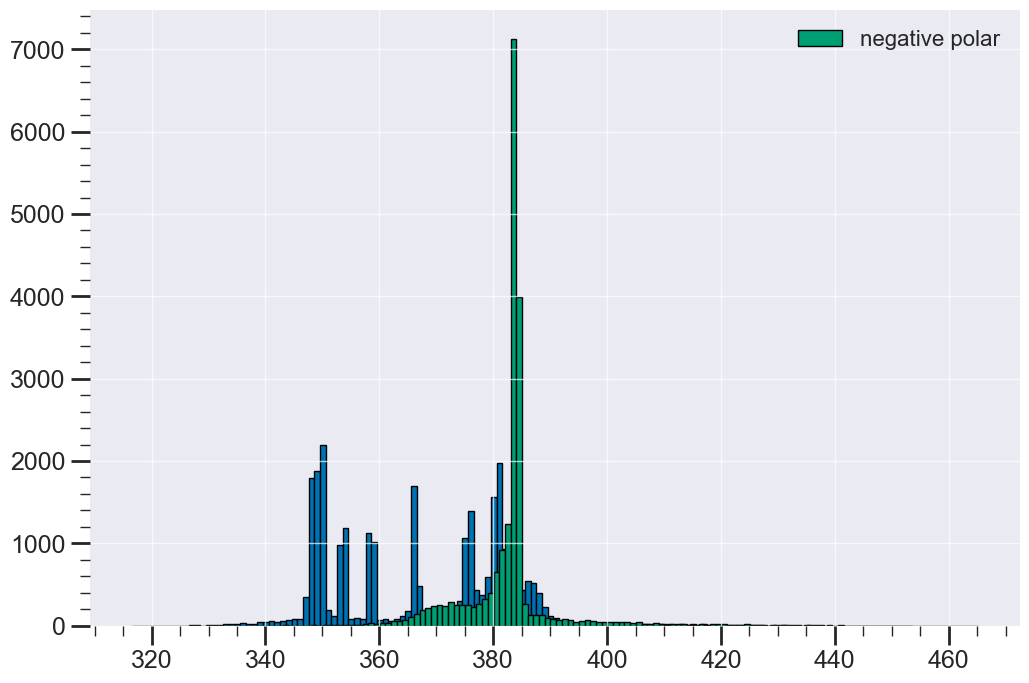

In [36]:
df_r = pickle.load(open(topdir+"reduced.p", "rb"))[0]
fig, ax = plt.subplots()
mask = (df_r["amp"] > 0) & (df_r["tau"] > 0)
pos_t = df_r[mask]["tau"]
bins = np.arange(min(pos_t), max(pos_t), 1)
ax.hist(pos_t, bins=bins)

mask = (df_r["amp"] < 0) & (df_r["tau"] > 0)
neg_t = df_r[mask]["tau"]
bins = np.arange(min(neg_t), max(neg_t), 1)
ax.hist(neg_t, bins=bins, label="negative polar")

ax.legend()
plt.show()


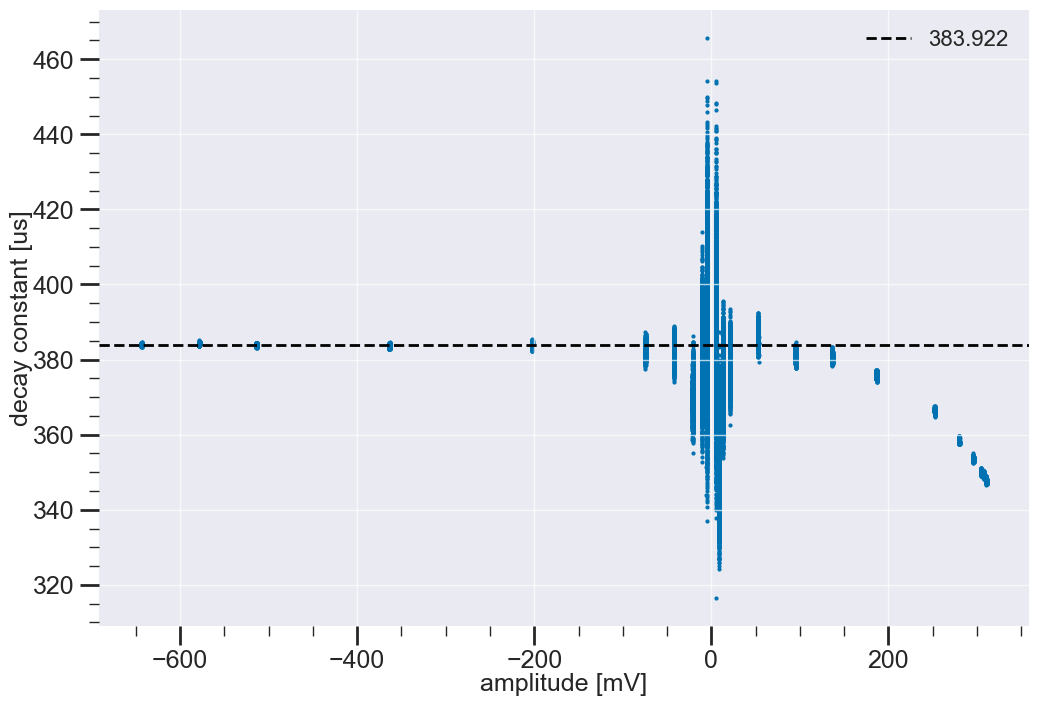

In [58]:
df_r = pickle.load(open(topdir+"reduced.p", "rb"))[0]
fig, ax = plt.subplots()

mask = df_r["tau"] > 0
dd = df_r[mask]

mask = dd["amp"] < -250
dd_neg = dd[mask]
fixed_tau = np.mean(dd_neg["tau"])

ax.scatter(dd["amp"], dd["tau"])
ax.axhline(fixed_tau, color='k', linestyle='--', label="{:.3f}".format(fixed_tau))
ax.set_xlabel("amplitude [mV]")
ax.set_ylabel("decay constant [us]")
ax.legend()
plt.show()


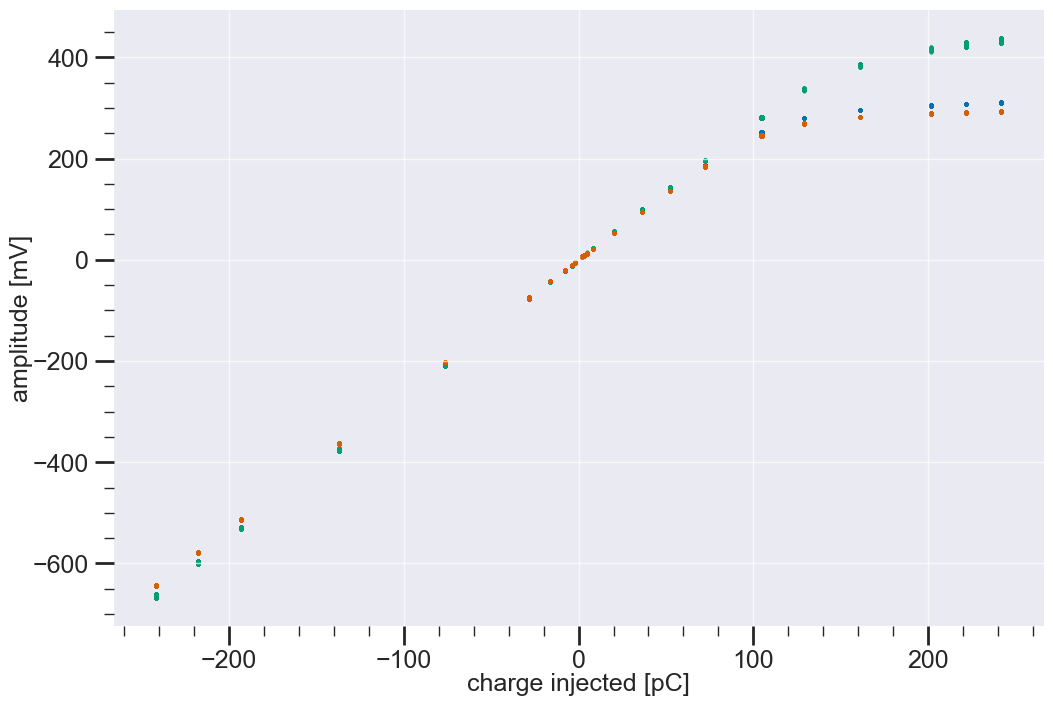

In [63]:
df_r = pickle.load(open(topdir+"reduced.p", "rb"))[0]
fig, ax = plt.subplots()

mask = df_r["tau"] > 0
dd = df_r[mask]

ax.scatter(dd["charge"], dd["amp"])
ax.scatter(dd["charge"], dd["max"])
ax.scatter(dd["charge"], dd["amp_fixed"])
ax.set_xlabel("charge injected [pC]")
ax.set_ylabel("amplitude [mV]")
#ax.set_ylim([-10, 150])
#ax.set_xlim([-10, 75])
plt.show()
